# Face Recognition using Eigenfaces

**Author: Brian van den Berg**

This notebook contains a Face Recognition engine based on Eigenfaces. The implementation relies solely on OpenCV packages, as required.

To execute this notebook, you need to install the following packages:
- pip install opencv-python
- pip install opencv-contrib-python
- pip install numpy
- pip install matplotlib
- pip install scikit-learn

In [32]:
import sys
import os
import csv
import time
import random
import pickle

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cv2
import sklearn
from sklearn.model_selection import train_test_split

print("Version Register:")
print(f'- Python: {sys.version}')
print(f'- OpenCV: {cv2.__version__}')
print(f'- Numpy: {np.__version__}')
print(f'- Matplotlib: {matplotlib.__version__}')
print(f'- Scikit-learn: {sklearn.__version__}')


Version Register:
- Python: 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
- OpenCV: 4.8.1
- Numpy: 1.26.2
- Matplotlib: 3.8.2
- Scikit-learn: 1.3.2


## Loading in Data

The Face Recognition model is trained using the dataset provided in the CSV file located at 'input/datasets/recognition.csv'. The data consists of image file paths and corresponding labels.

In [33]:
INPUT_FOLDER = os.path.join('input', 'datasets', 'recognition')
EIGENFACE_TRAINING_DATA = os.path.join(INPUT_FOLDER, 'recognition.csv')
CLASS_LABEL_FILENAME = 'class_dictionary.pkl'
EIGENFACE_CLASS_LABELS = os.path.join(INPUT_FOLDER, CLASS_LABEL_FILENAME)

# Load the class dictionary from the pickle file
with open(EIGENFACE_CLASS_LABELS, 'rb') as file:
    loaded_class_dictionary = pickle.load(file)

# Initialize an empty Feature and Label list
X = []
Y = []

# Read the CSV file and collect rows
with open(EIGENFACE_TRAINING_DATA, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)

    # Skip the header row
    _ = next(csv_reader)

    # Read and append each row to the list
    for row in csv_reader:
        # Prepare the image
        image = cv2.imread(row[0], cv2.IMREAD_GRAYSCALE)
        image_normalized = ((image - image.min()) / (image.max() - image.min())) * 255

        X.append(image_normalized.astype(np.uint8))
        Y.append(int(row[1]))

# Convert the list of features and labels to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.025, random_state=round(time.time()))

# Print the shapes
print('Original Data Shapes:')
print(f'- Features: {X.shape}')
print(f'- Labels: {Y.shape}')

Original Data Shapes:
- Features: (14, 64, 64)
- Labels: (14,)


## Visualization of Samples

A set of functions is provided for visualizing images within the context of the Face Recognition project.

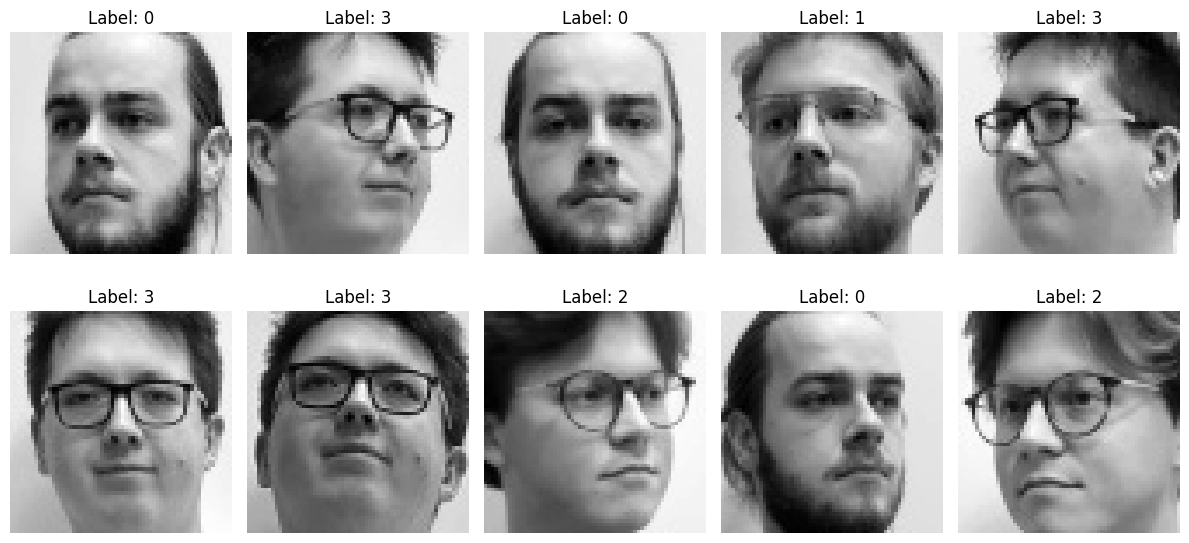

In [34]:
def display_random_samples(X, Y, num_samples=10, num_cols=5, num_rows=1, figsize=(12, 6)):
    if num_samples > len(X):
        num_samples = len(X)
    selected_indices = random.sample(range(X.shape[0]), num_samples)

    # Manage the sub-plots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Ensure axes is a 2D array, even for a single row
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    # Display the random samples in the sub-plots
    for i, idx in enumerate(selected_indices):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].imshow(X[idx], cmap='gray')
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_title(f'Label: {Y[idx]}')
    
    # Hide empty sub-plots
    for i in range(num_samples, num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axes[row_idx, col_idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
def display_all_in_order(X, num_cols=5, figsize=(12, 6)):
    num_images = X.shape[0]
    
    # Manage the sub-plots
    num_rows = int(np.ceil(num_images / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Display all images in order in the sub-plots
    for i in range(num_images):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].imshow(X[i], cmap='gray')
        axes[row_idx, col_idx].axis('off')

    # Hide empty sub-plots
    for i in range(num_images, num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axes[row_idx, col_idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()

def display_single_image(image, cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

# Show 10 random samples
display_random_samples(X, Y, num_samples=10, num_cols=5, num_rows=2, figsize=(12, 6))

## Preprocessing

The following code cells outline a pipeline for preprocessing images within the Face Recognition project.

### Reshape the Features

The following code cell demonstrates the process of reshaping the features for the Face Recognition model.

In [35]:
# Flatten the images
windowShape = X_train[0].shape
X_train_flattened = np.array([image.reshape(-1) for image in X_train])

print('Transformed Data:')
print(f'- Original Shape: {windowShape}')
print(f'- New Shape: {X_train_flattened[0].shape}')

Transformed Data:
- Original Shape: (64, 64)
- New Shape: (4096,)


### Calculate the Average Face

The code calculates the weighted average face from a set of flattened images in the training dataset.

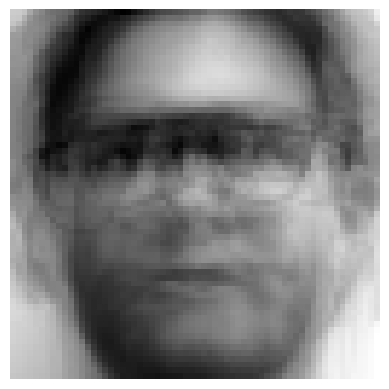

In [36]:
# Calculate the mean face
image_weight = 1 / len(X_train_flattened)
mean = np.zeros(len(X_train_flattened[0]))
for flat_image in X_train_flattened:
    mean += (image_weight * flat_image)

# Display the average face
display_single_image(mean.reshape(windowShape))

### Normalize faces

The code subtracts the mean from the flattened training features to normalize them.

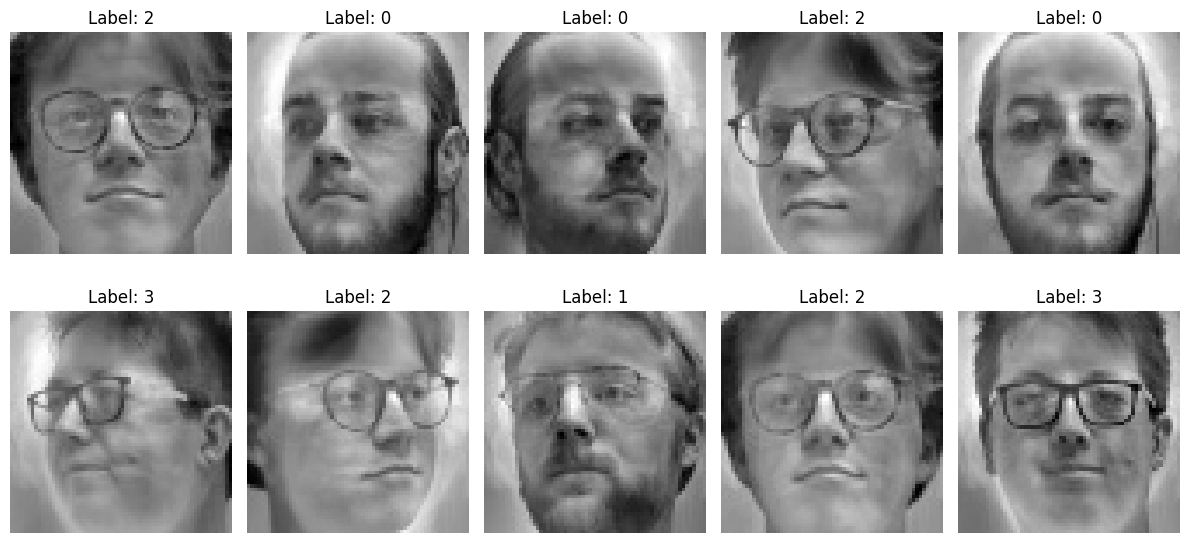

In [37]:
# Normalize the data
X_train_normalized = X_train_flattened - mean

# Show 10 random samples
X_viewable = np.array([image.reshape(windowShape) for image in X_train_normalized])
display_random_samples(X_viewable, Y_train, num_samples=10, num_cols=5, num_rows=2, figsize=(12, 6))

### Calculate Actual Eigenfaces

The code applies Principal Component Analysis (PCA) to the normalized training features, calculates eigenvectors, and selects the top 40 eigenfaces for visualization.

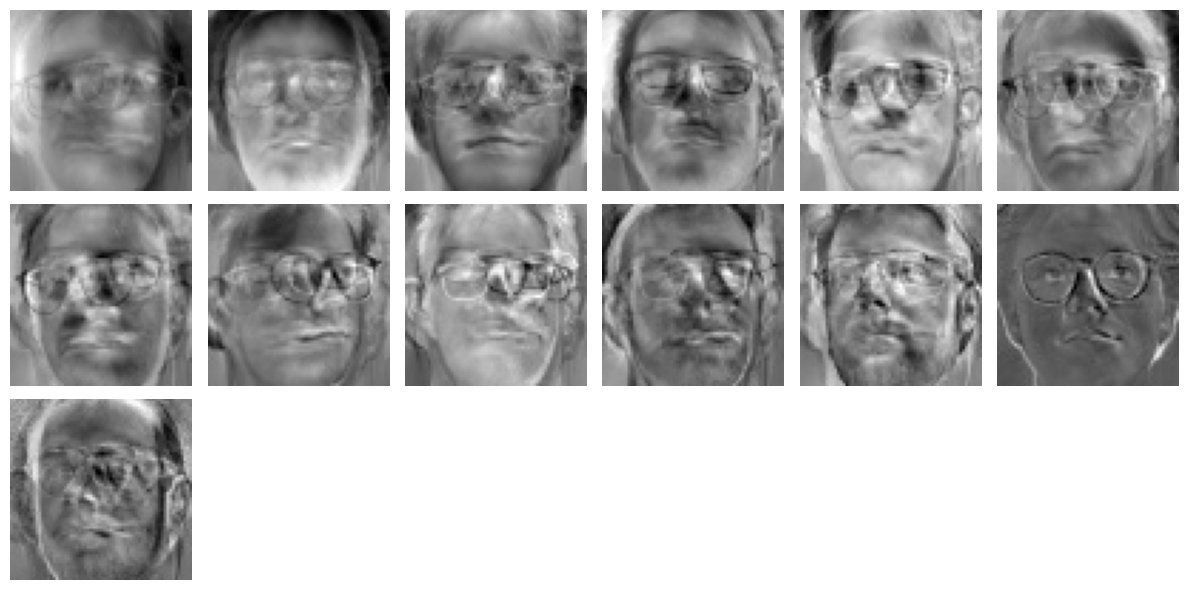

In [38]:
# Calculate the eigenvectors
_, eigenvectors = cv2.PCACompute(X_train_normalized, mean=None)

# Take the 40 best eigenfaces
best_eigenfaces = []
for eigenface in eigenvectors[0 : 40]:
   best_eigenfaces.append(eigenface)
best_eigenfaces = np.array(best_eigenfaces)

# Display the eigenvectors
best_eigenfaces_viewable = np.array([image.reshape(windowShape) for image in best_eigenfaces])
display_all_in_order(best_eigenfaces_viewable, 6)

## Model

The code creates an EigenFace Recognizer, projects the normalized training data onto the eigenface subspace, and trains the recognizer using the projected data and corresponding labels.

In [39]:
# Project training data onto the eigenface subspace
X_train_projected = np.dot(X_train_normalized, best_eigenfaces.T)

# Create an EigenFace Recognizer
recognizer = cv2.face.EigenFaceRecognizer().create()

# Train the recognizer with the projected training data and labels
recognizer.train(X_train_projected, Y_train)

## Application

The following steps are aimed at using and saving the model to allow and demonstrate usage outside of this Python Notebook

### Face Recognition

The code iterates through each test face, preprocesses it, projects it onto the eigenface subspace, and uses a trained EigenFace Recognizer to predict labels. The predictions are then displayed alongside corresponding test face samples.

Predictions made by the Algorithm:


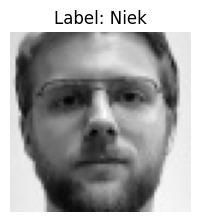

In [40]:
# Initialize a list to store the predicted labels
Y_pred = []

# Iterate through each test face
for face in X_test:
    # Preprocess the Test Face
    face_flat = face.reshape(-1)
    face_normalized = face_flat - mean
    face_projected = np.dot(face_normalized, best_eigenfaces.T)

    # Recognize the face using the trained recognizer
    label, confidence = recognizer.predict(face_projected)

    # Store the predicted label
    Y_pred.append(label)

# Convert the list of predicted labels to a numpy array
Y_pred = np.array(Y_pred)

# Map the numeric labels to names
Y_pred_names = np.vectorize(loaded_class_dictionary.get)(Y_pred)

# Display random samples with predicted labels
print("Predictions made by the Algorithm:")
display_random_samples(X_test, Y_pred_names, num_samples=40, num_cols=5, num_rows=8, figsize=(10, 16))

### Save the Model and Eigenfaces

The code creates a 'models' directory if it doesn't exist and saves the top 40 eigenfaces, mean face, eigenface shape array, and the trained EigenFace Recognizer to corresponding files.

In [41]:
os.makedirs('models', exist_ok=True)

# Save best_eigenfaces
np.save(os.path.join('models', 'best_eigenfaces.npy'), best_eigenfaces)

# Save mean face
np.save(os.path.join('models', 'mean_face.npy'), mean)

# Convert the tuple to a NumPy array
face_shape = np.array(windowShape)

# Save the eigenface shape array
np.save(os.path.join('models', 'target_shape.npy'), face_shape)

# Save EigenFaceRecognizer
recognizer.save(os.path.join('models', 'recognizer.yml'))

# Save the class dictionary
with open(os.path.join('models', CLASS_LABEL_FILENAME), 'wb') as file:
    pickle.dump(loaded_class_dictionary, file)